In [27]:
#Import Libraries
# Pandas allows importing data from various file formats such as comma-separated values, SQL, Microsoft Excel. 
import pandas as pd
# numpy perform a number of mathematical operations
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import itertools as itt
#from pmdarima.arima import ndiffs,nsdiffs
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn import metrics
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [28]:
#Read the data
df = pd.read_csv(r'yahoo_stock.csv',header=0)
df.head()

,Date,High,Low,Open,Close,Volume,Adj Close
0,2015-11-23,2095.610107,2081.389893,2089.409912,2086.590088,3.587980e+09,2086.590088
1,2015-11-24,2094.120117,2070.290039,2084.419922,2089.139893,3.884930e+09,2089.139893
2,2015-11-25,2093.000000,2086.300049,2089.300049,2088.870117,2.852940e+09,2088.870117
3,2015-11-26,2093.000000,2086.300049,2089.300049,2088.870117,2.852940e+09,2088.870117
4,2015-11-27,2093.290039,2084.129883,2088.820068,2090.110107,1.466840e+09,2090.110107


In [29]:
# Prepare index for date column & see the first five rows of given dataset
df.index = pd.DatetimeIndex(df.Date, freq='D')
df=df.drop(columns='Date')
df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2015-11-23,2095.610107,2081.389893,2089.409912,2086.590088,3.587980e+09,2086.590088
2015-11-24,2094.120117,2070.290039,2084.419922,2089.139893,3.884930e+09,2089.139893
2015-11-25,2093.000000,2086.300049,2089.300049,2088.870117,2.852940e+09,2088.870117
2015-11-26,2093.000000,2086.300049,2089.300049,2088.870117,2.852940e+09,2088.870117
2015-11-27,2093.290039,2084.129883,2088.820068,2090.110107,1.466840e+09,2090.110107


In [30]:
#Lets find the shape or size of an array or matrix
df.shape

(1825, 6)

In [31]:
# create a data type object
print(df.dtypes)

High         float64
Low          float64
Open         float64
Close        float64
Volume       float64
Adj Close    float64
dtype: object


In [32]:
#Evaluate the number of missing values in the data set
df.isnull().sum()

High         0
Low          0
Open         0
Close        0
Volume       0
Adj Close    0
dtype: int64

#### Non null values. Dataset complete

## Visualization

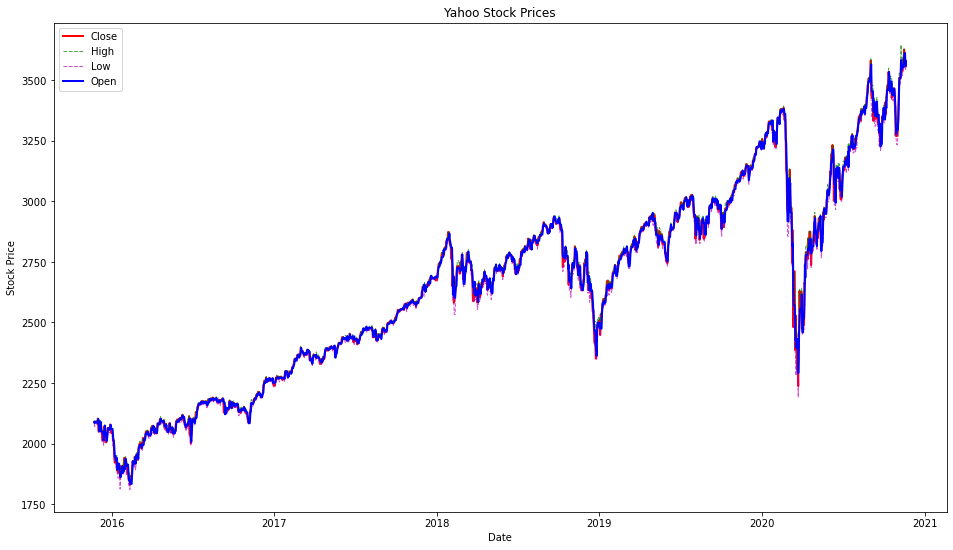

In [33]:
#creates a plotting area in a figure with respect to all features i.e. close, open,high, low, etc.
plt.figure(figsize=(16,9))

plt.plot(df.index, df.Close, lw=2, color='r',label='Close')
plt.plot(df.index, df.High, lw=1, color='g',linestyle='--',alpha=0.7,label='High')
plt.plot(df.index, df.Low, lw=1, color='m',linestyle='--',alpha=0.7,label='Low')
plt.plot(df.index, df.Open, lw=2, color='b',label='Open')

plt.legend()
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Yahoo Stock Prices')
plt.show()

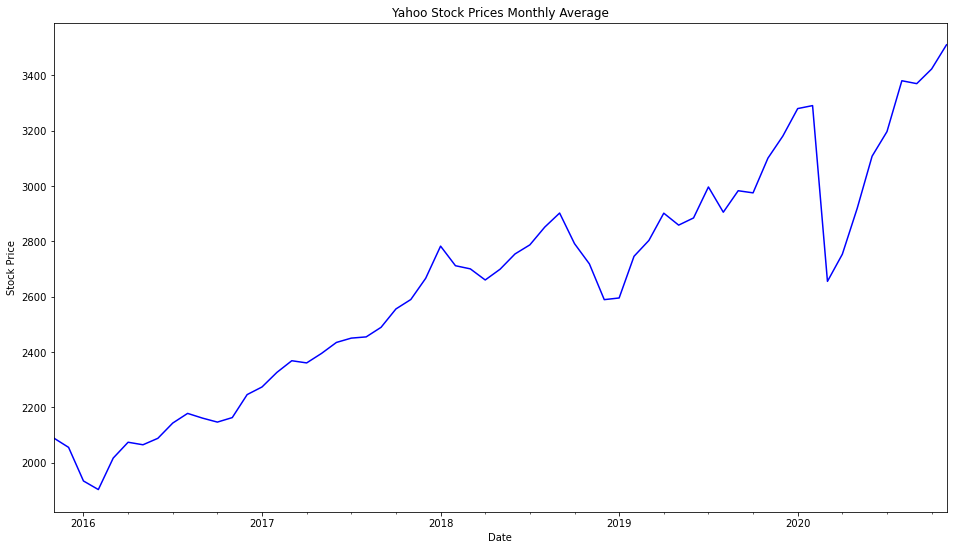

In [34]:
# lects see the relation between date & Opening Price of the stock
df_open_month_avg = df['Open'].resample('MS').mean()

plt.figure(figsize=(16,9))

df_open_month_avg.plot(color='b')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Yahoo Stock Prices Monthly Average')

plt.show()

### Search Seasonality for SARIMA

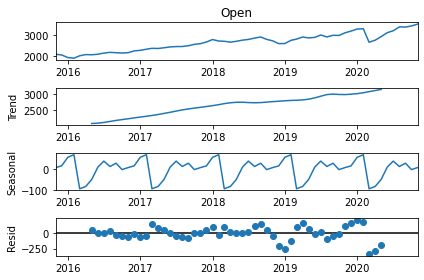

In [35]:
S = seasonal_decompose(df_open_month_avg,model='add')
S.plot()
plt.show()

In [36]:
def adf_test(timeseries):
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

print(adf_test(df_open_month_avg))

Results of Dickey-Fuller Test:
Test Statistic                 -0.409031
p-value                         0.908580
#Lags Used                      0.000000
Number of Observations Used    60.000000
Critical Value (1%)            -3.544369
Critical Value (5%)            -2.911073
Critical Value (10%)           -2.593190
dtype: float64
None


Results of Dickey-Fuller Test:
Test Statistic                -7.106214e+00
p-value                        4.047416e-10
#Lags Used                     0.000000e+00
Number of Observations Used    5.900000e+01
Critical Value (1%)           -3.546395e+00
Critical Value (5%)           -2.911939e+00
Critical Value (10%)          -2.593652e+00
dtype: float64
None


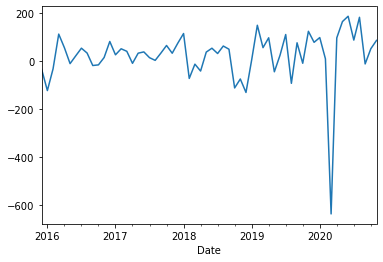

In [37]:
df_open_t_adj = df_open_month_avg - df_open_month_avg.shift(1)
df_open_t_adj = df_open_t_adj.dropna()
df_open_t_adj.plot()

print(adf_test(df_open_t_adj))

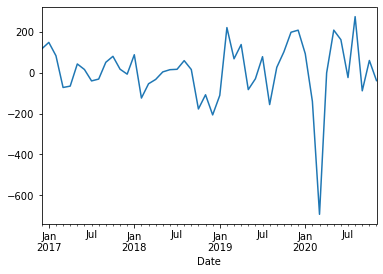

In [38]:
df_open_s_adj = df_open_t_adj - df_open_t_adj.shift(12)
df_open_s_adj = df_open_s_adj.dropna()
df_open_s_adj.plot()
plt.show()

### Autocorrelation & Partial Autocorrelation

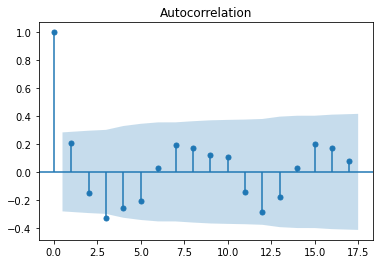

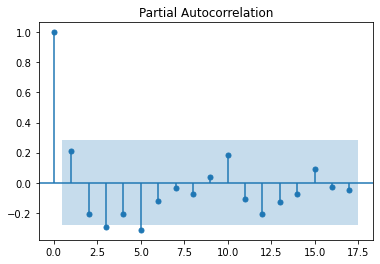

In [39]:
plot_acf(df_open_s_adj)
plt.show()
plot_pacf(df_open_s_adj)
plt.show()

In [40]:
'''
For ACF plot, initial spikes at lag = 1 and seasonal spikes at lag = 4 which means a probable AR order of 1 
and AR seasonal order of 0 or 1.
For PACF plot, initial spikes at lag = 1 and seasonal spikes at lag = 4,6 which means a probable MA order of 1 
and MA seasonal order od 0 or 1 or 2.
'''

'\nFor ACF plot, initial spikes at lag = 1 and seasonal spikes at lag = 4 which means a probable AR order of 1 \nand AR seasonal order of 0 or 1.\nFor PACF plot, initial spikes at lag = 1 and seasonal spikes at lag = 4,6 which means a probable MA order of 1 \nand MA seasonal order od 0 or 1 or 2.\n'

In [41]:
'''
The max values for SARIMA are  (1,1,1)x(1,0,1)12 
Let's GridSearch the best values depending on AIC result
'''

"\nThe max values for SARIMA are  (1,1,1)x(1,0,1)12 \nLet's GridSearch the best values depending on AIC result\n"

In [42]:
import warnings
p = range(0, 3)
d = range(1,2)
q = range(0, 3)
pdq = list(itt.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itt.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

params=[]
params_seasonal=[]
AIC = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
         with warnings.catch_warnings():
            warnings.filterwarnings("ignore")
            try:
                mod = SARIMAX(df_open_month_avg,
                              order=param,
                              seasonal_order=param_seasonal,
                              enforce_stationarity=False,
                              enforce_invertibility=False)
                results = mod.fit()
                if results.aic > 50:
                    params.append(param)
                    params_seasonal.append(param_seasonal)
                    AIC.append(results.aic)
                    
            except:
                continue
GS_params = pd.DataFrame(list(zip(params,params_seasonal,AIC)))
Best_params=GS_params.loc[GS_params[2].idxmin()]
print('Best Parameters had been: ARIMA{0}x{1} - AIC:{2}'.format(Best_params[0],Best_params[1],Best_params[2]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 1, 1) x (0, 1, 1, 12)
SARIMAX: (0, 1, 1) x (0, 1, 2, 12)
SARIMAX: (0, 1, 2) x (1, 1, 0, 12)
SARIMAX: (0, 1, 2) x (1, 1, 1, 12)
Best Parameters had been: ARIMA(2, 1, 1)x(1, 1, 1, 12) - AIC:160.48668694171624


In [43]:
series_to_pred =df_open_month_avg

y_index = series_to_pred.index

date_train = int(len(y_index)*0.9)

y_train = series_to_pred[y_index[:date_train]]
y_test = series_to_pred[y_index[date_train:len(y_index)]]

series_to_pred = series_to_pred.asfreq('MS')
y_train= y_train.asfreq('MS')
y_test= y_test.asfreq('MS')

y_train.tail()

Date
2019-12-01    3180.542583
2020-01-01    3280.052278
2020-02-01    3290.842075
2020-03-01    2655.194509
2020-04-01    2753.391300
Freq: MS, Name: Open, dtype: float64

In [44]:
y_test.head()

Date
2020-05-01    2919.494849
2020-06-01    3107.825334
2020-07-01    3196.793867
2020-08-01    3380.722893
2020-09-01    3370.259985
Freq: MS, Name: Open, dtype: float64

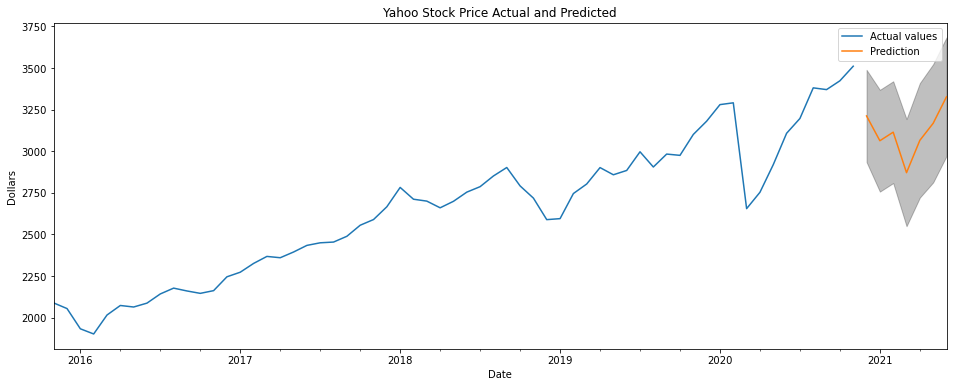

In [45]:
pred_uc = results.get_forecast(steps = len(y_test), dynamic=True)
pred_ci = pred_uc.conf_int()

ax = series_to_pred.plot(label = 'Actual values', figsize = (16, 6))

pred_uc.predicted_mean.plot(ax = ax, label = 'Prediction')

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color = 'k', alpha = .25)

ax.set_xlabel('Date')
ax.set_ylabel('Dollars')
ax.set_title('Yahoo Stock Price Actual and Predicted')

plt.legend()
plt.show()

In [46]:
y_pred = pred_ci.iloc[:, 0]
y_test=y_test.fillna(np.mean(y_test))
rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
print("The ARIMA model with paremeters {}x{}, has given an rmse in test of {}".format((0,1,2), (0,1,2,12),round(rmse, 2)))

The ARIMA model with paremeters (0, 1, 2)x(0, 1, 2, 12), has given an rmse in test of 541.06


In [47]:
series_to_pred = series_to_pred.asfreq('MS')
mod = SARIMAX(series_to_pred,
              order = (0,1,2),
              seasonal_order = (0,1,2,12),
              enforce_stationarity = False,
              enforce_invertibility = False)

results = mod.fit()

C:\Users\Paresh\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


In [48]:
forecast_res = results.get_forecast(steps = 12)
forecast_ci = forecast_res.conf_int()

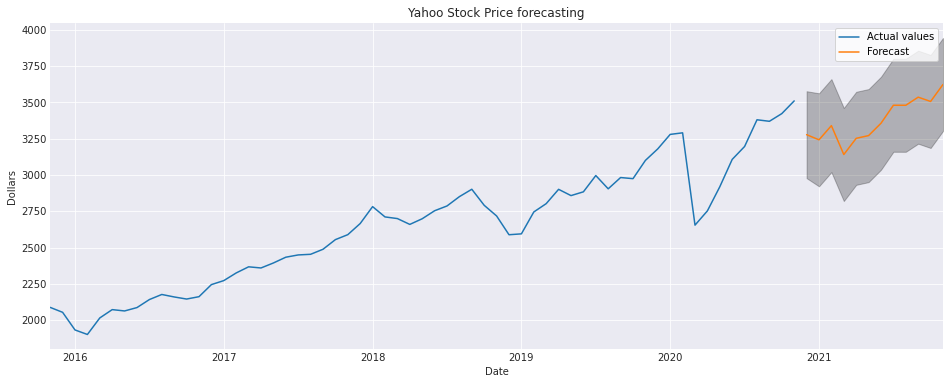

In [49]:
with plt.style.context("seaborn-darkgrid"):

    ax = series_to_pred.plot(label = 'Actual values', figsize = (16, 6))
    
    forecast_res.predicted_mean.plot(ax = ax, label = 'Forecast')

    ax.fill_between(forecast_ci.index,
                    forecast_ci.iloc[:, 0],
                    forecast_ci.iloc[:, 1], color = 'k', alpha = .25)
    ax.set_xlabel('Date')
    ax.set_ylabel('Dollars')


plt.title("Yahoo Stock Price forecasting")
plt.legend()
plt.show()

In [ ]:
series_to_pred.to_excel("Yahoo_forecasting.xlsx",index=True)